In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
df = pd.read_csv('housing.csv')
df.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11ce89e80>,
      dtype=object)

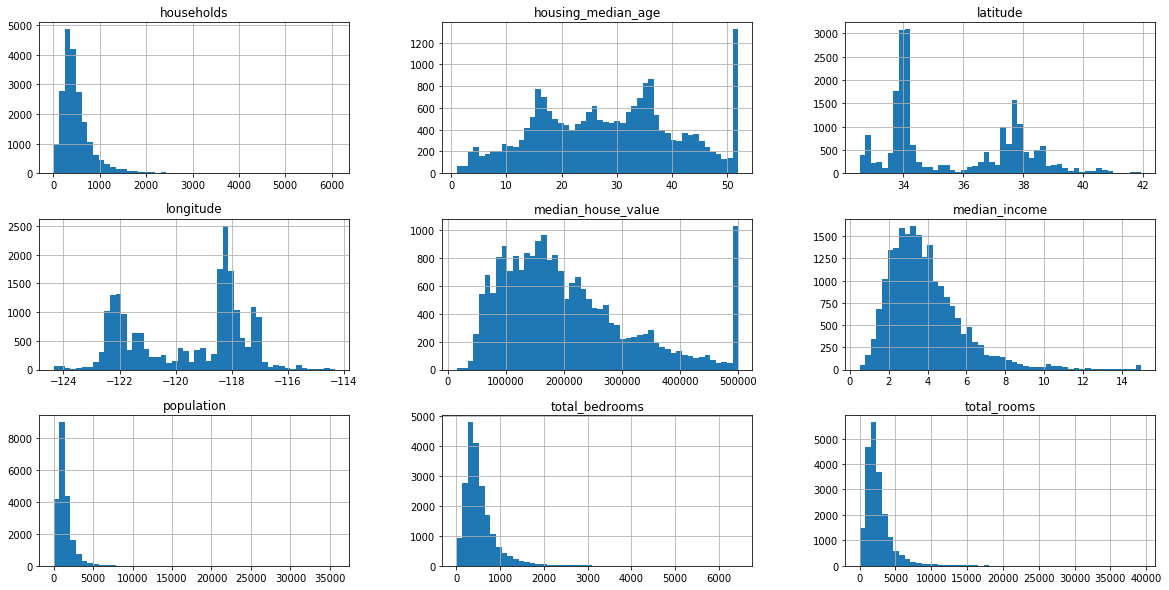

In [3]:
df.hist(bins=50,figsize=(20,10))

In [4]:
from sklearn.model_selection import train_test_split
train_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

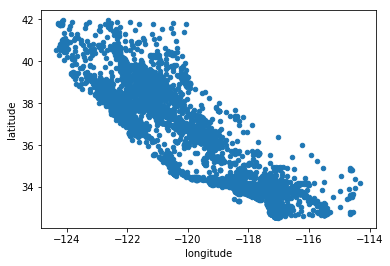

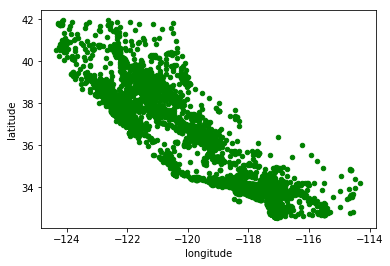

In [5]:
df.plot(kind ='scatter',x = 'longitude', y = 'latitude')
train_set.plot(kind ='scatter',x = 'longitude', y = 'latitude', c = 'g')

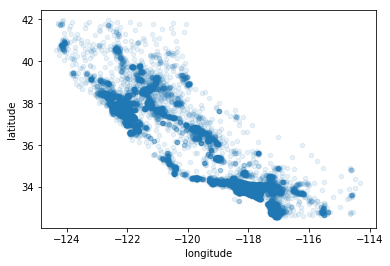

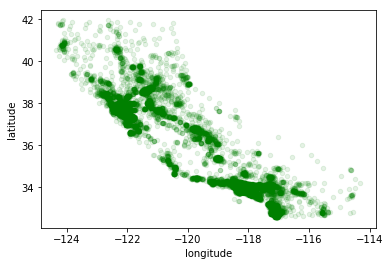

In [6]:
df.plot(kind ='scatter',x = 'longitude', y = 'latitude', alpha = 0.1)
train_set.plot(kind ='scatter',x = 'longitude', y = 'latitude', alpha = 0.1, c = 'g')

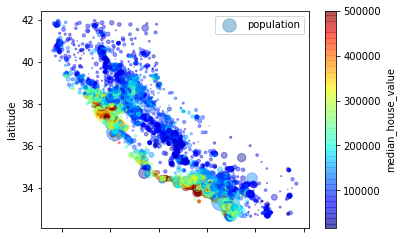

In [7]:
df.plot(kind="scatter", x="longitude", y="latitude", alpha=0.4,
s=df["population"]/100, label="population",
c="median_house_value", cmap=plt.get_cmap("jet"), colorbar=True) 
plt.legend()

In [8]:
df["rooms_per_household"] = df["total_rooms"]/df["households"]
df["bedrooms_per_room"] = df["total_bedrooms"]/df["total_rooms"]
df["population_per_household"]=df["population"]/df["households"]

In [9]:
corr = df.corr()
corr['median_house_value'].sort_values(ascending = False)

median_house_value          1.000000
median_income               0.688075
rooms_per_household         0.151948
total_rooms                 0.134153
housing_median_age          0.105623
households                  0.065843
total_bedrooms              0.049686
population_per_household   -0.023737
population                 -0.024650
longitude                  -0.045967
latitude                   -0.144160
bedrooms_per_room          -0.255880
Name: median_house_value, dtype: float64

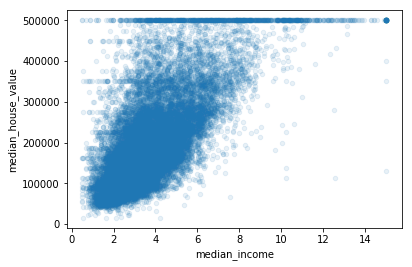

In [10]:
df.plot(kind='scatter',x = 'median_income', y = 'median_house_value', alpha = 0.1)

# create preprocessing pipeline

In [11]:
features = [x for x in list(train_set) if x != 'median_house_value']
df_xtrain = train_set[features]
df_ytrain = train_set['median_house_value']

df_xtest = test_set[features]
df_ytest = test_set['median_house_value']

num_attribs = [x for x in features if x != 'ocean_proximity']
cat_attribs = ['ocean_proximity']

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin
rooms_ix, bedrooms_ix, population_ix, household_ix = 3, 4, 5, 6

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room = True): # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room
    def fit(self, X, y=None):
        return self # nothing else to do
    def transform(self, X, y=None):
        rooms_per_household = X[:, rooms_ix] / X[:, household_ix]
        population_per_household = X[:, population_ix] / X[:, household_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[X, rooms_per_household, population_per_household, bedrooms_per_room]
        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [13]:
from sklearn.base import BaseEstimator, TransformerMixin
class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
         self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [14]:
# OneHotEncoder is not compatible with Pipeline
# https://stackoverflow.com/questions/42204250/how-to-do-onehotencoding-in-sklearn-pipeline

class CustomLabelBinarizer(BaseEstimator, TransformerMixin):
    def __init__(self, sparse_output=False):
        self.sparse_output = sparse_output
    def fit(self, X, y=None):
        return self
    def transform(self, X, y=None):
        enc = LabelBinarizer(sparse_output=self.sparse_output)
        return enc.fit_transform(X)

In [15]:
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.impute import SimpleImputer 
from sklearn.preprocessing import StandardScaler, LabelBinarizer

cat_attribs = ["ocean_proximity"]
num_pipeline = Pipeline([
('selector', DataFrameSelector(num_attribs)),
('imputer', SimpleImputer(strategy="median")),
('attribs_adder', CombinedAttributesAdder()),
('std_scaler', StandardScaler()),
])

cat_pipeline = Pipeline([
('selector', DataFrameSelector(cat_attribs)),
('OneHot', CustomLabelBinarizer()),
])


full_pipeline = FeatureUnion(transformer_list=[
("num_pipeline", num_pipeline),
("cat_pipeline", cat_pipeline),
])

In [16]:
df_xtrain_prepared = full_pipeline.fit_transform(df_xtrain)
df_xtest_prepared = full_pipeline.fit_transform(df_xtest)

In [17]:
df_xtrain_prepared[:5,:]

array([[ 1.27258656, -1.3728112 ,  0.34849025,  0.22256942,  0.21122752,
         0.76827628,  0.32290591, -0.326196  , -0.17491646,  0.05137609,
        -0.2117846 ,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 0.70916212, -0.87669601,  1.61811813,  0.34029326,  0.59309419,
        -0.09890135,  0.6720272 , -0.03584338, -0.40283542, -0.11736222,
         0.34218528,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.44760309, -0.46014647, -1.95271028, -0.34259695, -0.49522582,
        -0.44981806, -0.43046109,  0.14470145,  0.08821601, -0.03227969,
        -0.66165785,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [ 1.23269811, -1.38217186,  0.58654547, -0.56148971, -0.40930582,
        -0.00743434, -0.38058662, -1.01786438, -0.60001532,  0.07750687,
         0.78303162,  0.        ,  0.        ,  0.        ,  0.        ,
         1.        ],
       [-0.10855122,  0.5320839 ,  1

In [18]:
df_xtest_prepared[:5,:]

array([[ 0.25541734,  0.22194113, -0.30073951, -0.50056608, -0.24196995,
        -0.02654818, -0.3578599 , -1.14237625, -0.43367721,  0.52022395,
         0.76724738,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [ 0.02976613, -0.20947715,  0.098724  ,  0.15038025, -0.24196995,
         0.12876364,  0.22245041, -0.69050482, -0.13050312, -0.16293193,
        -0.82211069,  0.        ,  1.        ,  0.        ,  0.        ,
         0.        ],
       [-1.46454628,  1.03788441,  1.85636346,  0.55190278, -0.24196995,
        -0.10016419,  1.19995088, -0.18616932, -0.51063381, -0.91557569,
        -1.20734433,  0.        ,  0.        ,  0.        ,  1.        ,
         0.        ],
       [ 0.400837  , -0.61275946, -0.93988113,  0.19926913, -0.24196995,
         0.2544495 , -0.00709456,  1.01380686,  0.27182354,  0.27323743,
        -0.88099247,  1.        ,  0.        ,  0.        ,  0.        ,
         0.        ],
       [-1.20880825,  0.48454357,  0

In [19]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(df_xtrain_prepared, df_ytrain)



/usr/local/lib/python3.7/site-packages/sklearn/linear_model/base.py:485: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  linalg.lstsq(X, y)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [20]:
from sklearn.metrics import mean_squared_error
train_pred = lin_reg.predict(df_xtrain_prepared) 
test_pred = lin_reg.predict(df_xtest_prepared) 

train_mse = mean_squared_error(df_ytrain, train_pred)
test_mse = mean_squared_error(df_ytest, test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print ('train_rmse = {}, test_rmse = {}'.format(train_rmse,test_rmse))

train_rmse = 67593.20745775253, test_rmse = 71067.06604346127


In [21]:
print (train_pred[:5])
print (df_ytrain[:5])

[181746.54359616 290558.74973505 244957.50017771 146498.51061398
 163230.42393939]
14196    103000
8267     382100
17445    172600
14265     93400
2271      96500
Name: median_house_value, dtype: int64


In [22]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor()
tree_reg.fit(df_xtrain_prepared, df_ytrain)

train_pred = tree_reg.predict(df_xtrain_prepared) 
test_pred = tree_reg.predict(df_xtest_prepared) 

train_mse = mean_squared_error(df_ytrain, train_pred)
test_mse = mean_squared_error(df_ytest, test_pred)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

print ('train_rmse = {}, test_rmse = {}'.format(train_rmse,test_rmse))

train_rmse = 0.0, test_rmse = 103960.33772275494


In [23]:
from sklearn.model_selection import cross_val_score
scores = cross_val_score(tree_reg, df_xtest_prepared, df_ytest,
scoring="neg_mean_squared_error", cv=10)
rmse_scores = np.round(np.sqrt(-scores),2)

rmse_scores

array([85003.88, 79643.99, 75882.27, 82388.63, 85421.34, 74325.06,
       75827.25, 80317.52, 74104.06, 75021.22])

In [24]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

param_grid = [
{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]},
{'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]},
]
forest_reg = RandomForestRegressor()
grid_search = GridSearchCV(forest_reg, param_grid, cv=5,
scoring='neg_mean_squared_error')
grid_search.fit(df_xtrain_prepared, df_ytrain)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators='warn', n_jobs=None,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'n_estimators': [3, 10, 30], 'max_features': [2, 4, 6, 8]}, {'bootstrap': [False], 'n_estimators': [3, 10], 'max_features': [2, 3, 4]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [25]:
grid_search.best_params_

{'max_features': 6, 'n_estimators': 30}

In [26]:
cvres = grid_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

63663.71485557574 {'max_features': 2, 'n_estimators': 3}
54792.959386301205 {'max_features': 2, 'n_estimators': 10}
52481.90708395252 {'max_features': 2, 'n_estimators': 30}
59575.00092364795 {'max_features': 4, 'n_estimators': 3}
52599.225736753426 {'max_features': 4, 'n_estimators': 10}
50019.741930922384 {'max_features': 4, 'n_estimators': 30}
59605.43436454014 {'max_features': 6, 'n_estimators': 3}
52076.0803558641 {'max_features': 6, 'n_estimators': 10}
49748.93965577998 {'max_features': 6, 'n_estimators': 30}
58485.092951009465 {'max_features': 8, 'n_estimators': 3}
51951.357819951394 {'max_features': 8, 'n_estimators': 10}
49869.58406662574 {'max_features': 8, 'n_estimators': 30}
62569.21319151408 {'bootstrap': False, 'max_features': 2, 'n_estimators': 3}
53704.898262568175 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
59420.733628200614 {'bootstrap': False, 'max_features': 3, 'n_estimators': 3}
52516.10277415958 {'bootstrap': False, 'max_features': 3, 'n_estimator

In [27]:
feature_importances = grid_search.best_estimator_.feature_importances_
feature_importances

array([8.02064109e-02, 6.79495020e-02, 4.00260510e-02, 1.73349884e-02,
       1.66081326e-02, 1.71659109e-02, 1.50183398e-02, 3.17003659e-01,
       6.17006233e-02, 1.04405599e-01, 7.90071655e-02, 1.48334537e-02,
       1.56014741e-01, 1.51501403e-04, 6.27030158e-03, 6.30361976e-03])

In [28]:
from sklearn.preprocessing import LabelEncoder
encoder = LabelEncoder()
encoder.fit_transform(df_xtrain["ocean_proximity"])

print (encoder.classes_)

['<1H OCEAN' 'INLAND' 'ISLAND' 'NEAR BAY' 'NEAR OCEAN']


In [29]:
extra_attribs = ["rooms_per_hhold", "pop_per_hhold", "bedrooms_per_room"]
cat_one_hot_attribs = list(encoder.classes_)
attributes = num_attribs + extra_attribs + cat_one_hot_attribs
sorted(zip(feature_importances, attributes), reverse=True)

[(0.317003658693191, 'median_income'),
 (0.15601474124122813, 'INLAND'),
 (0.10440559914493754, 'pop_per_hhold'),
 (0.08020641093021276, 'longitude'),
 (0.07900716554395917, 'bedrooms_per_room'),
 (0.06794950203925568, 'latitude'),
 (0.06170062329535896, 'rooms_per_hhold'),
 (0.040026050991465306, 'housing_median_age'),
 (0.017334988433942693, 'total_rooms'),
 (0.017165910891556557, 'population'),
 (0.01660813259718294, 'total_bedrooms'),
 (0.015018339803328111, 'households'),
 (0.014833453653312961, '<1H OCEAN'),
 (0.006303619756365928, 'NEAR OCEAN'),
 (0.006270301581450493, 'NEAR BAY'),
 (0.00015150140325179693, 'ISLAND')]

In [2]:
import numpy as np
np.median([1,2,3])

2.0